In [61]:
import re
import json
import nltk
import ssl
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# SSL workaround for nltk downloads
try:
    _create_unverified_https_context = ssl._create_unverified_context
    ssl._create_default_https_context = _create_unverified_https_context
except AttributeError:
    pass

nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))


# 1. Preprocess Text
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


# 2–5. Build TF-IDF, LSI, Extract Topics + Associate Documents
def analyze_topics(documents, n_topics=10, top_terms=10, top_docs=5):
    ids = [doc['id'] for doc in documents]
    raw_texts = [doc['raw_text'] for doc in documents]
    clean_texts = [preprocess(text) for text in raw_texts]

    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(clean_texts)

    svd = TruncatedSVD(n_components=n_topics, random_state=42)
    lsi_matrix = svd.fit_transform(tfidf_matrix)

    terms = vectorizer.get_feature_names_out()
    components = svd.components_

    # Build topic dictionary
    topics = []
    for idx, comp in enumerate(components):
        term_weights = zip(terms, comp)
        sorted_terms = sorted(term_weights, key=lambda x: x[1], reverse=True)[:top_terms]
        topic_keywords = [term for term, weight in sorted_terms]

        # Find top documents for this topic
        doc_scores = lsi_matrix[:, idx]
        top_doc_indices = np.argsort(doc_scores)[::-1][:top_docs]
        associated_docs = [{'id': ids[i], 'score': float(doc_scores[i])} for i in top_doc_indices]

        topics.append({
            'topic_id': idx,
            'keywords': topic_keywords,
            'top_documents': associated_docs
        })

    return topics


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielstephens/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
def get_lsi_components(data, n_components=200):
    docs = [preprocess(doc['raw_text']) for doc in data]
    ids = [doc['id'] for doc in data]

    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(docs)

    svd = TruncatedSVD(n_components=n_components)
    lsi_matrix = svd.fit_transform(tfidf_matrix)

    # Return as a DataFrame
    import pandas as pd
    lsi_df = pd.DataFrame(lsi_matrix, columns=[f'LSI_{i+1}' for i in range(n_components)])
    lsi_df['id'] = ids
    return lsi_df


In [63]:
# Connect to SQLite
import sqlite3


conn = sqlite3.connect("database/mydatabase.db")
cursor = conn.cursor()

final_output = []

for corpus in ["Corpus1"]:
    cursor.execute("SELECT id, document FROM documents WHERE corpus_name = ?", (corpus,))
    rows = cursor.fetchall()

    # print(f"Found {len(rows)} documents in corpus '{corpus}'.")
    for doc_id, doc_text in rows:
        final_output.append({
            "id": doc_id,
            "raw_text": doc_text
        })

In [64]:
response = get_lsi_components(final_output, 300)

In [53]:
import pandas as pd

In [65]:
df = pd.DataFrame(final_output)

In [66]:
df.head()

,id,raw_text
0,dat/us_train_data_final_OFFICIAL.jsonl_0,SECTION 1. SHORT TITLE.\n\n This Act may be...
1,dat/us_train_data_final_OFFICIAL.jsonl_1,SECTION 1. SHORT TITLE.\n\n This Act may be...
2,dat/us_train_data_final_OFFICIAL.jsonl_2,SECTION 1. SHORT TITLE.\n\n This Act may be...
3,dat/us_train_data_final_OFFICIAL.jsonl_3,SECTION 1. SHORT TITLE.\n\n This Act may be...
4,dat/us_train_data_final_OFFICIAL.jsonl_4,SECTION 1. SHORT TITLE.\n\n This Act may be...


In [67]:
response

,LSI_1,LSI_2,LSI_3,LSI_4,LSI_5,LSI_6,LSI_7,LSI_8,LSI_9,LSI_10,...,LSI_292,LSI_293,LSI_294,LSI_295,LSI_296,LSI_297,LSI_298,LSI_299,LSI_300,id
0,0.296589,0.046610,-0.120397,0.149608,-0.181541,-0.049793,0.010754,-0.033003,-0.038561,0.034736,...,0.022007,-0.000601,0.003938,-0.002916,-0.018980,-0.004887,-0.000909,-0.023279,-0.023198,dat/us_train_data_final_OFFICIAL.jsonl_0
1,0.311395,0.077797,-0.274343,0.033588,0.291112,-0.042888,0.014695,-0.052518,-0.003818,-0.003132,...,-0.004802,-0.020990,-0.043719,0.015606,-0.007226,0.002466,-0.041485,0.004455,0.010164,dat/us_train_data_final_OFFICIAL.jsonl_1
2,0.151472,-0.006247,-0.001078,0.031601,-0.064282,0.001648,0.037503,0.068705,0.019218,0.143031,...,0.001003,-0.019868,-0.003722,0.031261,-0.019439,0.023181,-0.028560,-0.003867,0.008762,dat/us_train_data_final_OFFICIAL.jsonl_2
3,0.297757,-0.031894,-0.114960,0.122850,-0.037800,-0.005778,-0.007830,-0.051255,0.073903,-0.051953,...,-0.001978,-0.005053,-0.039659,0.029093,-0.013748,0.026651,-0.014845,0.006953,0.007104,dat/us_train_data_final_OFFICIAL.jsonl_3
4,0.402034,-0.338239,0.112154,0.015009,-0.053866,-0.060718,-0.004274,-0.049263,0.239755,0.076924,...,0.014629,0.010369,-0.016782,0.005914,-0.004936,-0.001330,-0.015762,0.004749,-0.000940,dat/us_train_data_final_OFFICIAL.jsonl_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18944,0.252465,-0.322383,0.124239,-0.003604,0.118257,0.135015,0.029706,0.044665,-0.071074,0.031010,...,0.046117,0.002534,0.016140,0.027732,-0.060990,-0.007636,-0.003190,0.002850,0.013769,dat/us_train_data_final_OFFICIAL.jsonl_18944
18945,0.287583,-0.198938,0.086427,-0.047011,0.057475,0.097780,-0.005652,0.141451,-0.122332,-0.139213,...,-0.001589,0.007020,0.023560,-0.011147,0.028951,-0.003706,-0.012631,0.025755,-0.003511,dat/us_train_data_final_OFFICIAL.jsonl_18945
18946,0.225427,0.075517,0.016392,-0.093027,-0.037464,-0.058347,0.017252,0.086109,-0.091836,0.001662,...,0.048921,-0.002179,-0.000236,-0.018848,0.009384,-0.002568,0.040972,0.008821,-0.026649,dat/us_train_data_final_OFFICIAL.jsonl_18946
18947,0.168017,0.074275,0.061932,-0.087141,-0.077941,-0.110286,0.032408,0.080651,-0.115872,0.025109,...,0.010435,-0.029886,-0.008538,-0.021709,-0.035409,-0.031292,-0.022196,0.014288,0.004227,dat/us_train_data_final_OFFICIAL.jsonl_18947


In [68]:
merged_df = pd.merge(df, response, on="id", how="inner")

In [69]:
lsi_ = merged_df.iloc[: ,2:]

In [70]:
from sklearn.cluster import KMeans

# # Extract LSI component columns
# lsi_cols = [col for col in merged_df.columns if col.startswith('LSI')]
# X = df[lsi_cols].values

# Cluster into 10 topics
kmeans = KMeans(n_clusters=10, random_state=42)
merged_df['topic'] = kmeans.fit_predict(lsi_)


/Users/danielstephens/Desktop/TOVA/topic/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/danielstephens/Desktop/TOVA/topic/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


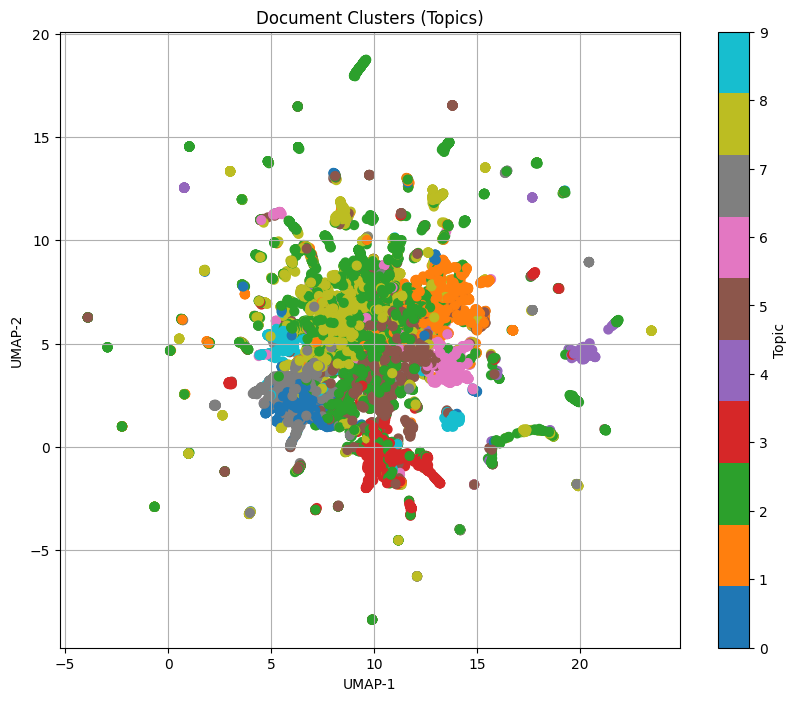

In [72]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(random_state=42)
X_2d = reducer.fit_transform(lsi_)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=merged_df['topic'], cmap='tab10', s=40)
plt.title("Document Clusters (Topics)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Topic")
plt.grid(True)
plt.show()


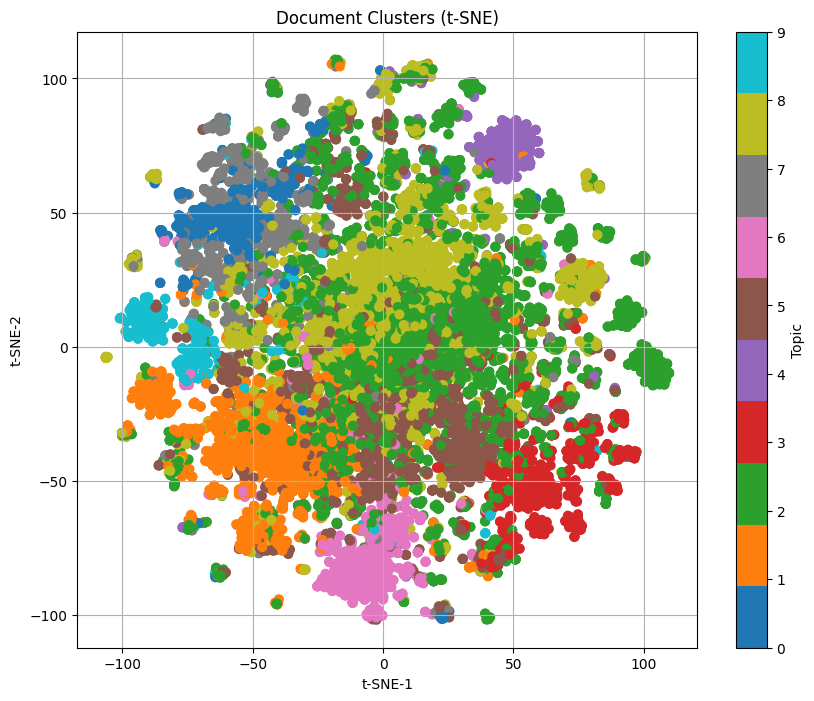

In [73]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(lsi_)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=merged_df['topic'], cmap='tab10', s=40)
plt.title("Document Clusters (t-SNE)")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.colorbar(label='Topic')
plt.grid(True)
plt.show()


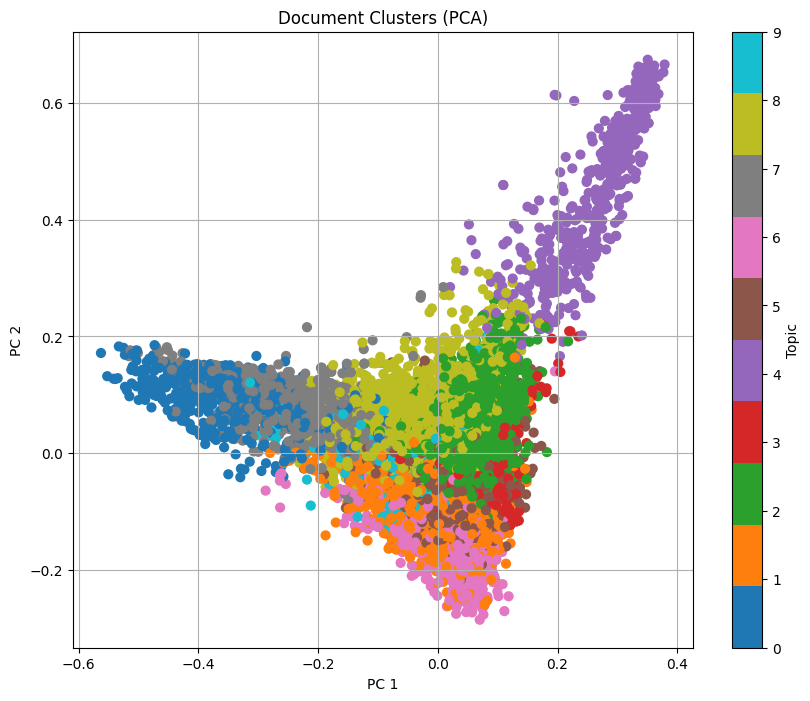

In [75]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(lsi_)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_df['topic'], cmap='tab10', s=40)
plt.title("Document Clusters (PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Topic')
plt.grid(True)
plt.show()


In [81]:
with open("output.jsonl", "w", encoding="utf-8") as f:
    for item in final_output:
        json.dump(item, f)
        f.write("\n")

In [86]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import numpy as np

# ----------------------
# 1. Load raw documents
# ----------------------
documents = final_output

# ----------------------
# 2. TF-IDF Vectorization
# ----------------------
texts = [doc["raw_text"] for doc in documents]
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

# ----------------------
# 3. Dimensionality Reduction (LSI)
# ----------------------
n_components = 200
lsi = TruncatedSVD(n_components=n_components, random_state=42)
lsi_matrix = lsi.fit_transform(tfidf_matrix)

# ----------------------
# 4. Clustering (KMeans)
# ----------------------
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(lsi_matrix)

# ----------------------
# 5. Score = Cosine Similarity to Cluster Centroid
# ----------------------
centroids = kmeans.cluster_centers_
scores = [
    cosine_similarity([lsi_matrix[i]], [centroids[clusters[i]]])[0][0]
    for i in range(len(documents))
]

# ----------------------
# 6. 2D PCA Projection for Plotting
# ----------------------
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(lsi_matrix)

# ----------------------
# 7. Top keywords per document
# ----------------------
# We'll take the top TF-IDF terms for each doc
top_k = 50
top_keywords_per_doc = []
for row in tfidf_matrix:
    row = row.toarray().flatten()
    top_indices = row.argsort()[::-1][:top_k]
    keywords = [feature_names[i] for i in top_indices if row[i] > 0]
    top_keywords_per_doc.append(keywords)

# ----------------------
# 8. Combine and Save to JSONL
# ----------------------
output_data = []
for i, doc in enumerate(documents):
    output_data.append({
        "id": doc["id"],
        "text": doc["raw_text"],
        "cluster": int(clusters[i]),
        "score": float(scores[i]),
        "pca": [float(x) for x in pca_coords[i]],
        "keywords": top_keywords_per_doc[i]
    })

# Save to JSONL
with open("static/data/output1.jsonl", "w", encoding="utf-8") as f:
    for item in output_data:
        json.dump(item, f)
        f.write("\n")
